# Classifying Blood Cell by Shape

## Charles Kulick, Jake Bentley, James McNeice

We begin by importing all needed libraries.

In [1]:
#Import all libraries.

#Import numpy.
import numpy as np

#Import matplotlib for visualization.
import matplotlib.pyplot as plt

#Import utilities.
import skimage
from skimage import util 
from skimage import feature
from skimage.measure import label   
from PIL import Image
from IPython.display import Image as ImageDisplay
import os
import time

#Import geomstats.
import geomstats
import warnings
warnings.filterwarnings("ignore")
import geomstats.backend as gs
from geomstats.geometry.pre_shape import PreShapeSpace
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

#Import learning tools.
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from geomstats.learning.preprocessing import ToTangentSpace
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean
from geomstats.learning.pca import TangentPCA

INFO: Using numpy backend


Next, we prepare to import our data. We declare how many images of each cell type we will use, and define utility methods for importing and image processing. Most of these steps were completed for the shapes assignment, and have only been refined for this final report.

In [2]:
#Declare a constant - number of images to use total.
NUM_IMAGES = 200

In [3]:
#Find the largest connected curve and erase any other extra curves.
def findLargestConnectedCurve(img):
    
    #Label each connected component with a different number.
    labelled = label(img)
    
    #Store number of occurances of each label.
    counts = [0] * (np.amax(labelled) + 1)
    
    #Count occurances of each label.
    for i in range(len(img)):
        for j in range(len(img[0])):
            counts[labelled[i][j]] += 1
    
    #We ignore 0, as this is background.
    counts[0] = 0
    
    #Get the index of the highest.
    highest = np.argmax(counts)
    
    #Return image with only these labels nonzero.
    connectedCurve = (labelled == highest)

    #Return result.    
    return connectedCurve



#Make a contour by using the above.
def makeContour(img, thresholdVal, sigmaVal):    
    
    #First, we convert to grayscale.
    grayimg = np.dot(img, [.3, .6, .1])

    #Then we invert because contours are drawn around lightest image parts,
    # while grayscale will have our area of interest be darkest.
    inv_gray_img = util.invert(grayimg)
    
    #We now threshold by the passed value.
    thresh = thresholdVal
    binaryImg = inv_gray_img > thresh
    
    #Canny edge detect to get contour.
    pic = feature.canny(binaryImg, sigma=sigmaVal)
    
    #Remove superfluous curves and return.
    return findLargestConnectedCurve(pic)



#Convert a 2D matrix into ordered curve form.
def orderedCurve(img, n):
    
    #Input: 2D matrix of 0s and 1s (off vs on curve), n = square size of image
    #Output: Ordered array of 2d coordinates of curve points
    
    #First, pick start point. 
    
    #We scan all pixels with value True into an array for easy access.
    pixelList = []
    for row in range(n):
        for col in range(n):
            if img[row][col]:
                pixelList.append([row, col])
                
    #Now pixelList is full. Pick a starting pixel.
    #We will pick any "ends" of the curve if they are present, and randomly if closed.
    out = []
    
    for pixel in pixelList:
        
        #Count number of neighbors.
        neighborCount = 0
        
        #Get coordinates.
        x = pixel[0]
        y = pixel[1]
        
        #Examine each neighbor.
        for neighbor in [[x,y-1], [x,y+1], [x-1,y], [x+1,y], [x-1,y-1], [x+1,y-1], [x-1,y+1], [x+1,y+1]]:
            r = neighbor[0]
            c = neighbor[1]
            if (0 <= r and r < n) and (0 <= c and c < n) and img[r][c]:
                #This neighbor is in the curve.
                neighborCount += 1
    
        #Test whether this is an open end.
        if neighborCount < 2:
            out.append(pixel)
            break
    
    #Handle edge case.
    if len(out) == 0:
        #The curve is truly closed. Choose randomly.    
        out = [pixelList[0]]    
    
    #Scan neighbors, first cordinal directions, then diagonals.
    #We choose the next pixel to append to our ordered output.
    while len(out) < len(pixelList):
        
        #Get most recent pixel.
        currentPixel = out[-1]
        x = currentPixel[0]
        y = currentPixel[1]
        
        #Store its neighbors.
        nbors = []
        
        #Look for valid unvisited neighbors.
        for neighbor in [[x,y-1], [x,y+1], [x-1,y], [x+1,y], [x-1,y-1], [x+1,y-1], [x-1,y+1], [x+1,y+1]]:
            r = neighbor[0]
            c = neighbor[1]
            if ((0 <= r and r < n) and (0 <= c and c < n)) and (img[r][c] and not neighbor in out):
                #This neighbor is in the curve.
                nbors.append(neighbor)
                
        #If we succeed, add to the list. 
        if len(nbors) > 0:
            out.append(nbors[0])
        else:
            
            #We're at a dead end. Jump to nearest pixel.            
            options = []
            dists = []
            for pixel in pixelList:
                if not (pixel in out) and (pixel[0] != x or pixel[1] != y):
                    options.append(pixel)
                    dists.append(abs(pixel[0] - x) + abs(pixel[1] - y))
                    
            #Get nearest pixel.
            minDist = min(dists)
            index = dists.index(minDist)
            
            #Choose the minimum index.
            out.append(options[index])

    #Out should be, roughly, an ordered list of pixels along the curve.
    return out

def GetContoursFromFolder(directory,number_of_contours, membrane):
    
    count = 0
    listfiles = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f) and count < number_of_contours:
            count += 1
            listfiles.append(f)
        
    new_list = []
    for i in range(number_of_contours):
        
        if i % 10 == 0:
            print(i)
            
        length = len(listfiles[i])
        Str2 = listfiles[i][length - 3:]
        if Str2 != 'jpg':
            new_list = new_list
        else:
            image = Image.open(listfiles[i])
            new_list.append(GetOutline(image, membrane))
    
    return new_list
    
    
def GetOutline(original_image, membrane = False):
    
    #Converts image into array and gray scales it
    image = np.array(original_image.convert('L'))

    if not membrane:
        
        #Get hist of image to set threshold
        counts, bins, bars = plt.hist(image.ravel(), bins = 256)
        amount = 0
        for i in range(15):
            amount = amount + counts[130+i]

        #clears historgram
        plt.clf()

        #customize the threshold
        if amount > 400:
            thresh_min = 110
        else:
            thresh_min = 60

        #Setting threshhold to get first outline
        image = image > thresh_min

        #Blur image by a lot
        image = skimage.filters.gaussian(image, sigma=5.0)

        #Threshold blurry image so that we get like an outline of original thresholded image
        image = image > 0.7

        #Get edge 
        image = feature.canny(image, sigma = 5.0)

        newim = image[15:345,15:345]

        #Get largest curve
        return findLargestConnectedCurve(newim)
    
    else:       
        
        #Send colors up
        image = 255.0 * (image/255.0)**4

        #Threshold
        thresh_min = 40

        #Setting threshhold to get first outline
        image = image > thresh_min

        #Blur image by a lot
        image = skimage.filters.gaussian(image, sigma=5.0)

        #Threshold blurry image so that we get like an outline of original thresholded image
        image = image > 0.80

        #Get edge 
        image = feature.canny(image, sigma = 5.0)
        
        newim = image[15:345,15:345]

        #Get largest curve
        return findLargestConnectedCurve(newim)

Now we import our data, and time this process for convenience. We also print regular updates to signal where in the process we are, as this is one of the most expensive steps. We import each type of cell using nucleus curve (N) and membrane curve (M).

In [4]:
start = time.time()

list_of_basophil_contours_N = GetContoursFromFolder('/Users/ckuli/Desktop/basophil',NUM_IMAGES, False)
list_of_basophil_contours_M = GetContoursFromFolder('/Users/ckuli/Desktop/basophil',NUM_IMAGES, True)

list_of_monocyte_contours_N = GetContoursFromFolder('/Users/ckuli/Desktop/monocyte',NUM_IMAGES,False)
list_of_monocyte_contours_M = GetContoursFromFolder('/Users/ckuli/Desktop/monocyte',NUM_IMAGES,True)

list_of_neutrophil_contours_N = GetContoursFromFolder('/Users/ckuli/Desktop/neutrophil',NUM_IMAGES,False)
list_of_neutrophil_contours_M = GetContoursFromFolder('/Users/ckuli/Desktop/neutrophil',NUM_IMAGES,True)

list_of_lymphocyte_contours_N = GetContoursFromFolder('/Users/ckuli/Desktop/lymphocyte',NUM_IMAGES,False)
list_of_lymphocyte_contours_M = GetContoursFromFolder('/Users/ckuli/Desktop/lymphocyte',NUM_IMAGES,True)

list_of_eosinophil_contours_N = GetContoursFromFolder('/Users/ckuli/Desktop/eosinophil',NUM_IMAGES,False)
list_of_eosinophil_contours_M = GetContoursFromFolder('/Users/ckuli/Desktop/eosinophil',NUM_IMAGES,True)

list_of_erythroblast_contours_N = GetContoursFromFolder('/Users/ckuli/Desktop/erythroblast',NUM_IMAGES,False)
list_of_erythroblast_contours_M = GetContoursFromFolder('/Users/ckuli/Desktop/erythroblast',NUM_IMAGES,True)

list_of_ig_contours_N = GetContoursFromFolder('/Users/ckuli/Desktop/ig',NUM_IMAGES,False)
list_of_ig_contours_M = GetContoursFromFolder('/Users/ckuli/Desktop/ig',NUM_IMAGES,True)

end = time.time()
print(end - start)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
545.1943254470825


<Figure size 640x480 with 0 Axes>

In [5]:
#Method to turn a list of contours to the correct datatype for curves.
def getCurveObjects(list_of_contours):
    
    processedCurves = []

    for i in range(len(list_of_contours)):
        OC = orderedCurve(list_of_contours[i], 330)
        newCurve = OC[0::10]
        path_coordinates = np.transpose(newCurve)
        processedCurves.append(np.transpose(path_coordinates))
                
    return processedCurves

We next transform each of these lists of contours into a list of curves for use in geomstats.

In [6]:
pc1N = getCurveObjects(list_of_basophil_contours_N)
pc2N = getCurveObjects(list_of_monocyte_contours_N)
pc3N = getCurveObjects(list_of_neutrophil_contours_N)
pc4N = getCurveObjects(list_of_lymphocyte_contours_N)
pc5N = getCurveObjects(list_of_eosinophil_contours_N)
pc6N = getCurveObjects(list_of_erythroblast_contours_N)
pc7N = getCurveObjects(list_of_ig_contours_N)

pc1M = getCurveObjects(list_of_basophil_contours_M)
pc2M = getCurveObjects(list_of_monocyte_contours_M)
pc3M = getCurveObjects(list_of_neutrophil_contours_M)
pc4M = getCurveObjects(list_of_lymphocyte_contours_M)
pc5M = getCurveObjects(list_of_eosinophil_contours_M)
pc6M = getCurveObjects(list_of_erythroblast_contours_M)
pc7M = getCurveObjects(list_of_ig_contours_M)

Next, using Dr. Miolane's excellent functions from geomstats and class material, we set up interpolation of curves, exhaustive alignment, and a basic helper function to apply functions to lists.

In [7]:
#All credit to Dr. Miolane.
#Interpolate curve up to the desired number of points.
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation

#All credit to Dr. Miolane.
#Align curves by exhaustive checking.
def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_METRIC.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve

#Basic method to apply a function to all entries in a list.
def apply_fn_to_list(input_list, fn):
    
    output = []
    
    for item in input_list:
        output.append(fn(item))
        
    return output

#Basic method to turn curve datatypes into np arrays for later compatibility.
def turnInto2DArray(ar):
    
    out = np.zeros(shape=(len(ar),len(ar[0])))
    
    for i in range(len(ar)):
        for j in range(len(ar[i])):
            out[i,j] = ar[i][j]
            
    return np.array(out)

We can continue processing our data! We will interpolate up to 200 points, align, and turn the datatype into a numpy array for compatibility with later methods.

In [8]:
#Interpolate to 200 pts.
k_sampling_points = 200

#Define shape spaces and metrics.
M_AMBIENT = 2
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_space.metric

In [9]:
#Get interpolated curves for each list.
curves1N = apply_fn_to_list(pc1N, lambda x: interpolate(x, k_sampling_points))
curves2N = apply_fn_to_list(pc2N, lambda x: interpolate(x, k_sampling_points))
curves3N = apply_fn_to_list(pc3N, lambda x: interpolate(x, k_sampling_points))
curves4N = apply_fn_to_list(pc4N, lambda x: interpolate(x, k_sampling_points))
curves5N = apply_fn_to_list(pc5N, lambda x: interpolate(x, k_sampling_points))
curves6N = apply_fn_to_list(pc6N, lambda x: interpolate(x, k_sampling_points))
curves7N = apply_fn_to_list(pc7N, lambda x: interpolate(x, k_sampling_points))

curves1M = apply_fn_to_list(pc1M, lambda x: interpolate(x, k_sampling_points))
curves2M = apply_fn_to_list(pc2M, lambda x: interpolate(x, k_sampling_points))
curves3M = apply_fn_to_list(pc3M, lambda x: interpolate(x, k_sampling_points))
curves4M = apply_fn_to_list(pc4M, lambda x: interpolate(x, k_sampling_points))
curves5M = apply_fn_to_list(pc5M, lambda x: interpolate(x, k_sampling_points))
curves6M = apply_fn_to_list(pc6M, lambda x: interpolate(x, k_sampling_points))
curves7M = apply_fn_to_list(pc7M, lambda x: interpolate(x, k_sampling_points))

#Also combine curves for performing complete classification of all 7 types.
curvesN = curves1N + curves2N + curves3N + curves4N + curves5N + curves6N + curves7N
curvesM = curves1M + curves2M + curves3M + curves4M + curves5M + curves6M + curves7M

In [10]:
curvesN = curves1N + curves2N + curves3N + curves4N + curves5N + curves6N + curves7N
curvesM = curves1M + curves2M + curves3M + curves4M + curves5M + curves6M + curves7M

We now project the shapes, pick a base curve (arbitrarily the first one in the list), and align.

In [11]:
#Project the shapes.
shapes_projN = apply_fn_to_list(curvesN, PRESHAPE_SPACE.projection)
shapes_projM = apply_fn_to_list(curvesM, PRESHAPE_SPACE.projection)

#Pick a base curve.
BASE_CURVE_N = shapes_projN[0]
BASE_CURVE_M = shapes_projM[0]

#Align all to base curve.
shapes_alignN = apply_fn_to_list(shapes_projN, lambda x: exhaustive_align(x, BASE_CURVE_N))
shapes_alignM = apply_fn_to_list(shapes_projM, lambda x: exhaustive_align(x, BASE_CURVE_M))

#Save processed full shapes.
shapes_processedN = apply_fn_to_list(shapes_alignN, lambda x: turnInto2DArray(x))
shapes_processedM = apply_fn_to_list(shapes_alignM, lambda x: turnInto2DArray(x))

Now we're ready to try learning on the whole dataset!

In [12]:
#Make train/test splits.
trainN, testN = train_test_split(shapes_processedN)
trainM, testM = train_test_split(shapes_processedM)

In [13]:
#Now run the models that on the FULL dataset.
#First, we make a target y vector, somewhat inelegantly.
zeros = [0] * NUM_IMAGES
ones = [1] * NUM_IMAGES
twos = [2] * NUM_IMAGES
threes = [3] * NUM_IMAGES
fours = [4] * NUM_IMAGES
fives = [5] * NUM_IMAGES
sixes = [6] * NUM_IMAGES

target = zeros + ones + twos + threes + fours + fives + sixes

#Use a tangent Log Regression model.
lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=SRV_METRIC)),
        ("classifier", LogisticRegression(C=7)),
    ]
)

print("Using Nucleus Curves:")
X_train, X_test, y_train, y_test = train_test_split(curvesN, target)
lr_pipeline.fit(X_train, y_train)
print(f"Using Logistic Regression: Accuracy of {lr_pipeline.score(X_test, y_test):.2f}.")


mdm = RiemannianMinimumDistanceToMean(riemannian_metric=SRV_METRIC)
mdm.fit(np.array(X_train), np.array(y_train))
print(f"Using MDM: Accuracy of {mdm.score(np.array(X_test), np.array(y_test)):.2f}.")


print("Using Membrane Curves:")
X_train, X_test, y_train, y_test = train_test_split(curvesM, target)
lr_pipeline.fit(X_train, y_train)
print(f"Using Logistic Regression: Accuracy of {lr_pipeline.score(X_test, y_test):.2f}.")


mdm = RiemannianMinimumDistanceToMean(riemannian_metric=SRV_METRIC)
mdm.fit(np.array(X_train), np.array(y_train))
print(f"Using MDM: Accuracy of {mdm.score(np.array(X_test), np.array(y_test)):.2f}.")

Using Nucleus Curves:
Using Logistic Regression: Accuracy of 0.32.
Using MDM: Accuracy of 0.34.
Using Membrane Curves:
Using Logistic Regression: Accuracy of 0.25.
Using MDM: Accuracy of 0.27.


This accuracy is much better than random chance $(\sim 14 \%)$ but still struggles to compare to CNN accuracy rates for the entire dataset. To get a better idea of what is happening, we look at pairwise comparisons also. To show a full and scientifically ethical comparison, we keep all pairwise comparisons, though some are vastly worse.

In [14]:
#Very inelegant solution to making pairwise curve lists.
c12N = curves1N + curves2N; c13N = curves1N + curves3N; c14N = curves1N + curves4N; c15N = curves1N + curves5N; c16N = curves1N + curves6N; c17N = curves1N + curves7N
c23N = curves2N + curves3N; c24N = curves2N + curves4N; c25N = curves2N + curves5N; c26N = curves2N + curves6N; c27N = curves2N + curves7N
c34N = curves3N + curves4N; c35N = curves3N + curves5N; c36N = curves3N + curves6N; c37N = curves3N + curves7N
c45N = curves4N + curves5N; c46N = curves4N + curves6N; c47N = curves4N + curves7N
c56N = curves5N + curves6N; c57N = curves5N + curves7N; c67N = curves6N + curves7N
cNs = [c12N, c13N, c14N, c15N, c16N, c17N, c23N, c24N, c25N, c26N, c27N, c34N, c35N, c36N, c37N, c45N, c46N, c47N, c56N, c57N, c67N]

c12M = curves1M + curves2M; c13M = curves1M + curves3M; c14M = curves1M + curves4M; c15M = curves1M + curves5M; c16M = curves1M + curves6M; c17M = curves1M + curves7M
c23M = curves2M + curves3M; c24M = curves2M + curves4M; c25M = curves2M + curves5M; c26M = curves2M + curves6M; c27M = curves2M + curves7M
c34M = curves3M + curves4M; c35M = curves3M + curves5M; c36M = curves3M + curves6M; c37M = curves3M + curves7M
c45M = curves4M + curves5M; c46M = curves4M + curves6M; c47M = curves4M + curves7M
c56M = curves5M + curves6M; c57M = curves5M + curves7M; c67M = curves6M + curves7M
cMs = [c12M, c13M, c14M, c15M, c16M, c17M, c23M, c24M, c25M, c26M, c27M, c34M, c35M, c36M, c37M, c45M, c46M, c47M, c56M, c57M, c67M]

Our first comparison we can examine is using PCA to see if this problem could be approached through dimension reduction techniques. As we will see, this is not the most successful technique.

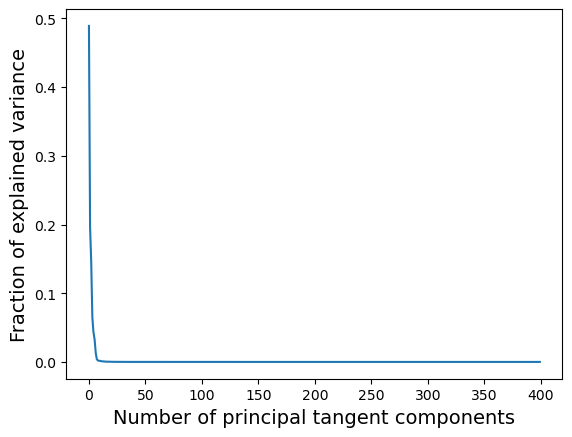

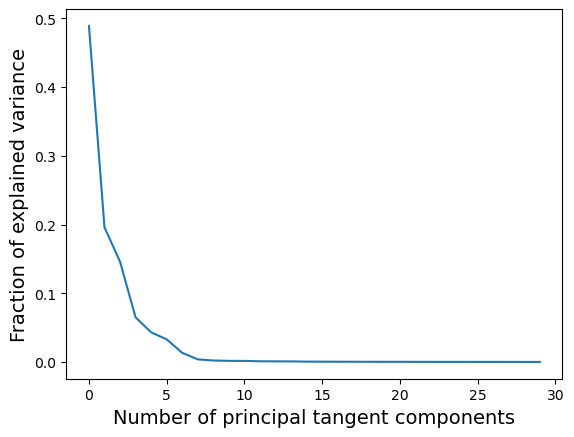

In [15]:
#Construct target vector.
zeros = [0] * NUM_IMAGES
ones = [1] * NUM_IMAGES
target = zeros + ones

#Use the 1/5 pair of curves.
X_train, X_test, y_train, y_test = train_test_split(c16N, target)

#Perform tangent PCA. Full plot of variance.
tpca = TangentPCA(SRV_METRIC)
tpca.fit(c16N)
plt.plot(tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14);
plt.show()

#Also show a zoomed-in plot.
plt.plot(tpca.explained_variance_ratio_[:30])
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14);
plt.show()

This is some evidence that we expect PCA to be somewhat lackluster on this data. We try to plot anyway!

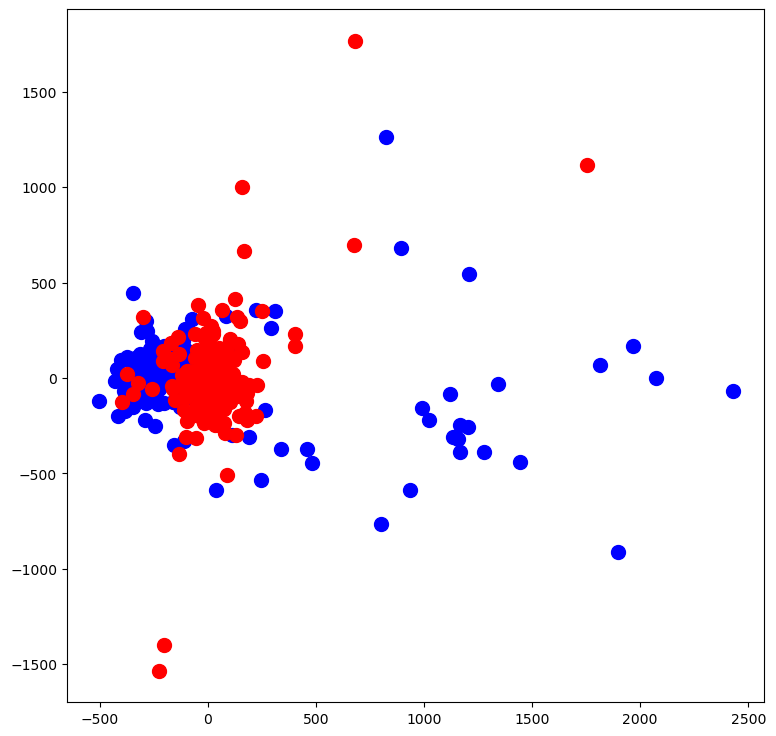

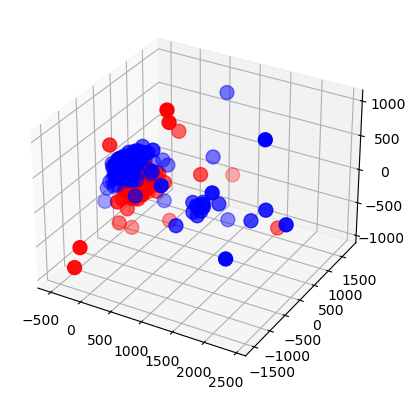

In [16]:
#Use tpca to plot the data in 2D.
XData = tpca.transform(c16N) 
plt.figure(figsize=(9, 9))
for label, col in [([0] * len(target), "blue"),([1] * len(target),"red")]:
    mask = (np.array(label) == np.array(target))
    plt.scatter(XData[mask, 0], XData[mask, 1], color=col, s=100)
plt.show()


#We now attempt to plot in 3D and see if there's an improvement.

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for label, col in [([0] * len(target), "blue"),([1] * len(target),"red")]:
    mask = (np.array(label) == np.array(target))
    ax.scatter(XData[mask, 0], XData[mask, 1], XData[mask, 2], color=col, s=100)
plt.show()

We can see the performance is not fantastic. We will have to use other learning methods, as dimension reduction alone does not look promising.

Now we use a KMeans comparison, as well as the logistic regression and MDM models used for the full dataset above. As evidenced by the performance of the methods previously, we will choose to uses a nucleus curve comparison.

In [17]:
#Store results for each comparison.
resultMeans = [0] * 21
resultReg = [0] * 21
resultMDM = [0] * 21

#First, iterate through nucleus curves.
for index, curveGrouping in enumerate(cNs):
    
    print("Next pairwise nucleus curve grouping:")
    train, test = train_test_split(curveGrouping)
    kmeans = RiemannianKMeans(PRESHAPE_METRIC, 2, tol=1e-5, init_step_size=1.0)
    kmeans.fit(np.array(train))
    predicted_labels = kmeans.predict(curveGrouping)
    
    #Get results for kmeans.
    zeros = [0] * NUM_IMAGES
    ones = [1] * NUM_IMAGES

    #One issue - images may be clustered as either 0s or 1s.
    #We try both ways and take the higher accuracy.
    targetA = zeros + ones
    targetB = ones + zeros

    accA = (targetA == predicted_labels)
    accB = (targetB == predicted_labels)

    goodA = 0
    goodB = 0
    for i in accA:
        if i:
            goodA += 1
    for i in accB:
        if i:
            goodB += 1
            
    good = max(goodA, goodB)
    resultMeans[index] = (good * 1.0 / len(targetA))
    print(f"Using KMeans: Accuracy of {(good * 1.0 / len(targetA)):.2f}.")

    #Now we run logistic regression.
    lr_pipeline = Pipeline(
        steps=[
            ("trick_tangent_space", ToTangentSpace(geometry=SRV_METRIC)),
            ("classifier", LogisticRegression(C=2)),
        ]
    )

    X = curveGrouping
    y = targetA
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lr_pipeline.fit(X_train, y_train)
    print(f"Using Logistic Regression: Accuracy of {lr_pipeline.score(X_test, y_test):.2f}.")
    resultReg[index] = lr_pipeline.score(X_test, y_test)
    
    print("Now for the MDM model:")
    mdm = RiemannianMinimumDistanceToMean(riemannian_metric=SRV_METRIC)
    mdm.fit(np.array(X_train), np.array(y_train))
    print(f"Using MDM: Accuracy of {mdm.score(np.array(X_test), np.array(y_test)):.2f}.")
    resultMDM[index] = mdm.score(np.array(X_test), np.array(y_test))

Next pairwise nucleus curve grouping:
Using KMeans: Accuracy of 0.52.
Using Logistic Regression: Accuracy of 0.57.
Now for the MDM model:
Using MDM: Accuracy of 0.56.
Next pairwise nucleus curve grouping:
Using KMeans: Accuracy of 0.55.
Using Logistic Regression: Accuracy of 0.79.
Now for the MDM model:
Using MDM: Accuracy of 0.77.
Next pairwise nucleus curve grouping:
Using KMeans: Accuracy of 0.52.
Using Logistic Regression: Accuracy of 0.67.
Now for the MDM model:
Using MDM: Accuracy of 0.60.
Next pairwise nucleus curve grouping:
Using KMeans: Accuracy of 0.53.
Using Logistic Regression: Accuracy of 0.75.
Now for the MDM model:
Using MDM: Accuracy of 0.71.
Next pairwise nucleus curve grouping:
Using KMeans: Accuracy of 0.88.
Using Logistic Regression: Accuracy of 0.80.
Now for the MDM model:
Using MDM: Accuracy of 0.81.
Next pairwise nucleus curve grouping:
Using KMeans: Accuracy of 0.52.
Using Logistic Regression: Accuracy of 0.66.
Now for the MDM model:
Using MDM: Accuracy of 0.67

This shows roughly how the class comparisons break down between cells. We now plot these comparisons.

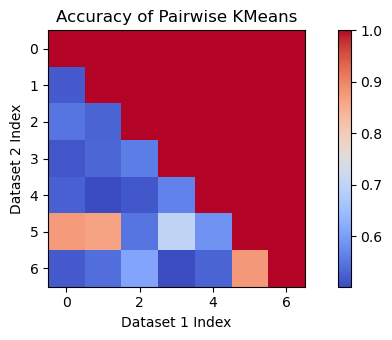

In [18]:
result = np.ones(shape=(7,7))
result[1:,0] = resultMeans[:6]
result[2:,1] = resultMeans[6:11]
result[3:,2] = resultMeans[11:15]
result[4:,3] = resultMeans[15:18]
result[5:,4] = resultMeans[18:20]
result[6:,5] = resultMeans[20]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(result, cmap="coolwarm")
plt.colorbar(im)
plt.xlabel("Dataset 1 Index")
plt.ylabel("Dataset 2 Index");
plt.title("Accuracy of Pairwise KMeans");
plt.show()

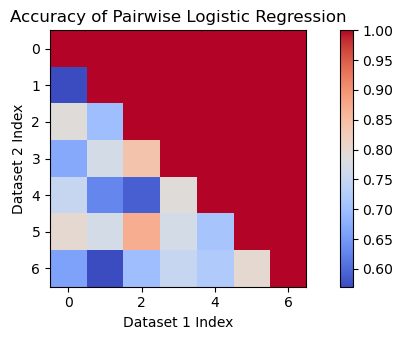

In [19]:
result = np.ones(shape=(7,7))
result[1:,0] = resultReg[:6]
result[2:,1] = resultReg[6:11]
result[3:,2] = resultReg[11:15]
result[4:,3] = resultReg[15:18]
result[5:,4] = resultReg[18:20]
result[6:,5] = resultReg[20]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(result, cmap="coolwarm")
plt.colorbar(im)
plt.xlabel("Dataset 1 Index")
plt.ylabel("Dataset 2 Index");
plt.title("Accuracy of Pairwise Logistic Regression");
plt.show()

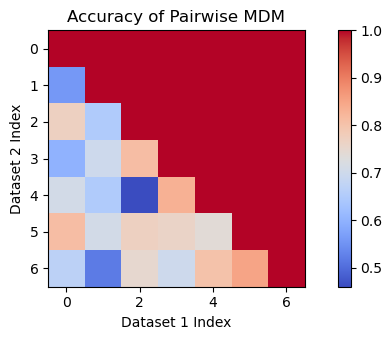

In [20]:
result = np.ones(shape=(7,7))
result[1:,0] = resultMDM[:6]
result[2:,1] = resultMDM[6:11]
result[3:,2] = resultMDM[11:15]
result[4:,3] = resultMDM[15:18]
result[5:,4] = resultMDM[18:20]
result[6:,5] = resultMDM[20]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(result, cmap="coolwarm")
plt.colorbar(im)
plt.xlabel("Dataset 1 Index")
plt.ylabel("Dataset 2 Index");
plt.title("Accuracy of Pairwise MDM");
plt.show()

Now, we can examine some differences between the good cell comparisons and lackluster cell comparisons. Let's look at a bad comparison first - the one between class 2 and class 4.

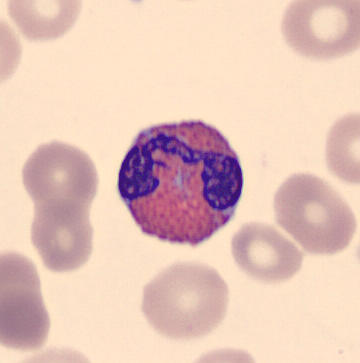

In [21]:
ImageDisplay("EO_8539.jpg")

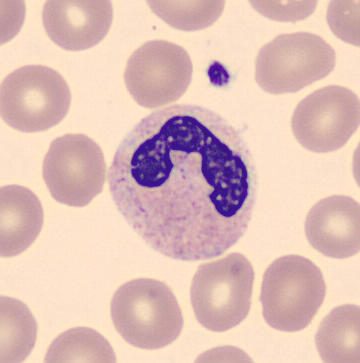

In [22]:
ImageDisplay("BNE_34065.jpg")

These nuclei are similar and thus are a harder learning problem for our classifier. On the other hand, let's look at a pair that performs favorably!

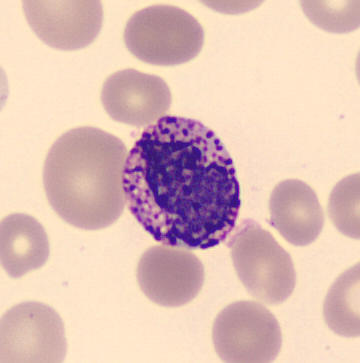

In [23]:
ImageDisplay("BA_25610.jpg")

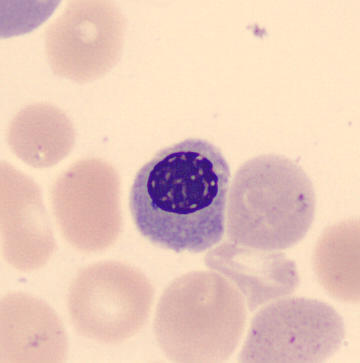

In [24]:
ImageDisplay("ERB_7817.jpg")

This distinction is way easier - in general, it is a classification between rougher and smoother boundary curves for the nucleus. This is well within our capacity for learning via statistical methods, and thus we perform very well!

Next, we look at learning rate over time. We use a pair of datasets that compares decently to show the progress.

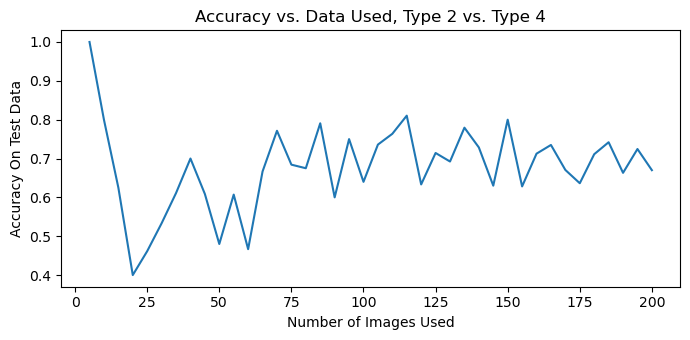

In [25]:
#Test learning at several sizes.
testNums = range(5,NUM_IMAGES + 1,5)

#Run essentially the same code as above for each test.
outReg = []
outMDM = []
for num in testNums:
    
    #Get results.
    zeros = [0] * num
    ones = [1] * num

    target = zeros + ones
    
    lr_pipeline = Pipeline(
        steps=[
            ("trick_tangent_space", ToTangentSpace(geometry=SRV_METRIC)),
            ("classifier", LogisticRegression(C=2)),
        ]
    )
    
    X = curves2N[:num] + curves4N[:num]
    y = target
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lr_pipeline.fit(X_train, y_train)
    outReg.append(lr_pipeline.score(X_test, y_test))
    
    mdm = RiemannianMinimumDistanceToMean(riemannian_metric=SRV_METRIC)
    mdm.fit(np.array(X_train), np.array(y_train))
    outMDM.append(mdm.score(np.array(X_test), np.array(y_test)))
    
    
plt.plot(testNums, outReg)
plt.xlabel("Number of Images Used")
plt.ylabel("Accuracy On Test Data");
plt.title("Accuracy vs. Data Used, Type 2 vs. Type 4");
plt.show()
    


In conclusion, these methods have interesting and stable behavior overall, with advantages over the naive CNN approach and with ample room for improvement in future work. If we keep more data about our cells and expand the methodology, this method shows real promise in application.

## References

Acevedo, A. et al. A dataset for microscopic peripheral blood cell images for development of automatic recognition
systems, https://doi.org/10.17632/snkd93bnjr.1 (2020).

Yang, J., Shi, R., Wei, D. et al. MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification. Sci Data 10, 41 (2023). https://doi.org/10.1038/s41597-022-01721-8

Miolane, Nina. Shape Analysis of Cancer Cells. https://geomstats.github.io/notebooks/11_real_world_applications__cell_shapes_analysis.html

Miolane, Nina. Lecture notes and class materials. Winter Quarter, 2023, UCSB.